**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Higher order income risk](#toc1_)    
- 2. [Problem 2: Inflation in an exchange model](#toc2_)    
- 3. [Problem 3: Segregation model](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
from types import SimpleNamespace
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
from matplotlib import colors
from scipy import optimize
from scipy import interpolate

%load_ext autoreload 
%autoreload 2

from opg2 import opg2_class
model = opg2_class()


## 1. <a id='toc1_'></a>[Problem 1: Higher order income risk](#toc0_)

We consider a consumer living in **two periods**. In the **second period** she behaves as:

$$
\begin{align*}
v_{2}(m_{2})	&=\max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho} \\
	&\text{s.t.} \\
a_{2}	&=m_{2}-c_{2} \\
a_{2}	&\geq0 \\
\end{align*}
$$

This implies:

$$
v_{2}(m_{2})=\frac{m_{2}^{1-\rho}}{1-\rho}
$$

In the **first period**, the consumer solves:

$$
\begin{align*}
v_{1}(m_{1})	&=\max_{c_{1}}\frac{c_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_{2}(m_{2})\right] \\
	&\text{s.t.} \\
a_{1}	&=m_{1}-c_{1} \\
a_{1}	&\geq0 \\
m_{2}	&=(1+r)a_{1}+y_{2} \\

y_{2}	&= \begin{cases}
1 & \nu_2 < \pi\\
\exp(\psi_2) & \text{else}
\end{cases} \\
\psi_2	&\sim\mathcal{N}(-0.5\sigma_{\psi}^{2},\sigma_{\psi}^{2}) \\
\nu_2	&\sim\mathcal{U}(0,1) \\
\end{align*}
$$

The standard random variables $\psi_2$ and $\nu_2$ are approximated with $N$ random draws.

The initial value of cash-on-hand is $m_1 = 1.0$.
The baseline parameters are as in the code below.

In [2]:
par = SimpleNamespace()

par.beta = 0.90
par.rho = 2.0
par.r = 0.05    
par.pi = 0.50
par.sigma_psi = 0.10

#OBS: In the model description we are told that the initial value of cash-on-hand is 1.0.
#     However, in the baseline parameters given to us, the initial value of cash-on-hand is 2.0.
#     We choose to set the initial value of cash-on-hand to 1.0, as this is what we are told from the model description.
par.m1 = 1.0 
par.N = 100_000

**Questions 1:** Plot the distribution of $y_2$.

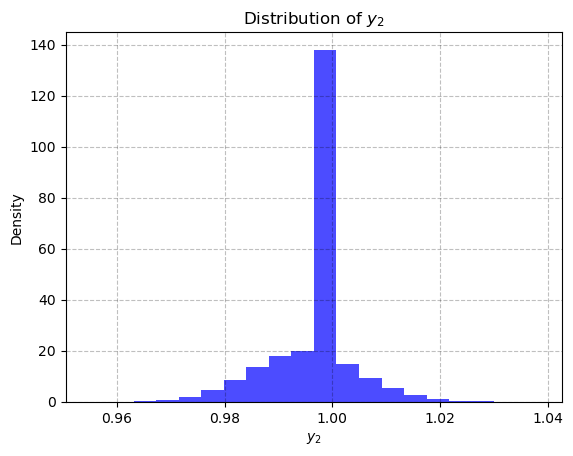

Mean of y2: 1.00
Median of y2: 1.00
Std Dev of y2: 0.01


In [3]:
# We perform a Monte Carlo simulation to generate values for y2
psi2_draws = np.random.normal(-0.5 * par.sigma_psi**2, par.sigma_psi**2, par.N) # Draw from the distribution of psi2
nu2_draws = np.random.uniform(0, 1, par.N) # Draw from the distribution of nu2
y2_values = np.where(nu2_draws < par.pi, 1, np.exp(psi2_draws)) # Calculate y2

# We set a random seed to ensure that we get the same results every time we run the code
np.random.seed(2023)

# Plot the distribution of y2
plt.hist(y2_values, bins=20, density=True, alpha=0.7, color='blue')
plt.xlabel('$y_2$')
plt.ylabel('Density')
plt.title('Distribution of $y_2$')

# Calculate summary statistics
mean_y2 = np.mean(y2_values)
median_y2 = np.median(y2_values)
std_dev_y2 = np.std(y2_values)

# Plot the distribution of y2
plt.show()
print((f"Mean of y2: {mean_y2:.2f}\nMedian of y2: {median_y2:.2f}\nStd Dev of y2: {std_dev_y2:.2f}"))


Here we see that the distribution of $y_2$ is more or less normally distributed around 1, with a standard deviation of 0.01

**Question 2:** Find the optimal choice of $c_1$ and the implied $v(m_1)$.

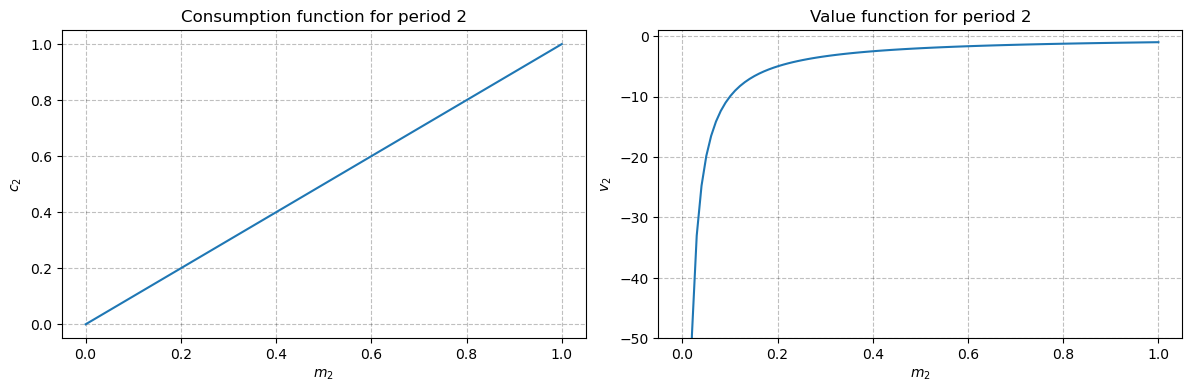

In [4]:
#First we set N = 100 because the loops are very slow
par.N = 100

# Generate random draws for nu2 and psi2
nu2_draws = np.random.uniform(0, 1, par.N)
psi2_draws = np.random.normal(-0.5 * par.sigma_psi**2, par.sigma_psi**2, par.N)

# Calculate y2_values based on nu2 and psi2
y2_values = np.where(nu2_draws < par.pi, 1, np.exp(psi2_draws))

# Function to calculate utility
def utility(c, par):
    return (c**(1-par.rho))/(1-par.rho)

# Define the value function for period 2
def v_last_period(c, m, par):
    return utility(c, par)

# Define the value function for period 1
def v(c, m, par, v_plus_interp):
    v_plus = 0.0
    for y in y2_values:
        a = m - c
        m_plus = (1 + par.r) * a + y
        v_plus_now = v_plus_interp(m_plus)[0]
        v_plus += y * v_plus_now  # Using y directly
    return utility(c, par) + par.beta * v_plus

def solve_last_period(par):
    m_grid = np.linspace(1e-8, par.m1, par.N)
    v_func = np.empty(par.N)
    c_func = np.empty(par.N)

    for i, m in enumerate(m_grid):
        obj = lambda c: -v_last_period(c, m, par) # Fix this line
        x0 = m / 2  # Initial guess of consumption
        result = optimize.minimize(obj, [x0], method='L-BFGS-B', bounds=((1e-8, m),))
        v_func[i] = -result.fun
        c_func[i] = result.x

    return m_grid, v_func, c_func

# Call the solve_last_period function
m2_grid,v2_func,c2_func = solve_last_period(par)

# Setup the plots for the functions
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(m2_grid, c2_func)
ax.set_xlabel('$m_2$')
ax.set_ylabel('$c_2$')
ax.set_title('Consumption function for period 2')

ax = fig.add_subplot(1,2,2)
ax.plot(m2_grid, v2_func)
ax.set_xlabel('$m_2$')
ax.set_ylabel('$v_2$')
ax.set_title('Value function for period 2')
ax.set_ylim([-50, 1])

fig.tight_layout(pad=1.0)
plt.show()

Here we see that the consumer chooses to consume all of her cash-on-hand in period 2. This makes perfectly good sense, as we are not working with a model in which a bequest is added to the maximization problem in the second period. Therefore, the consumer will optimize her utility by spending all of her cash-on-hand in period 2.

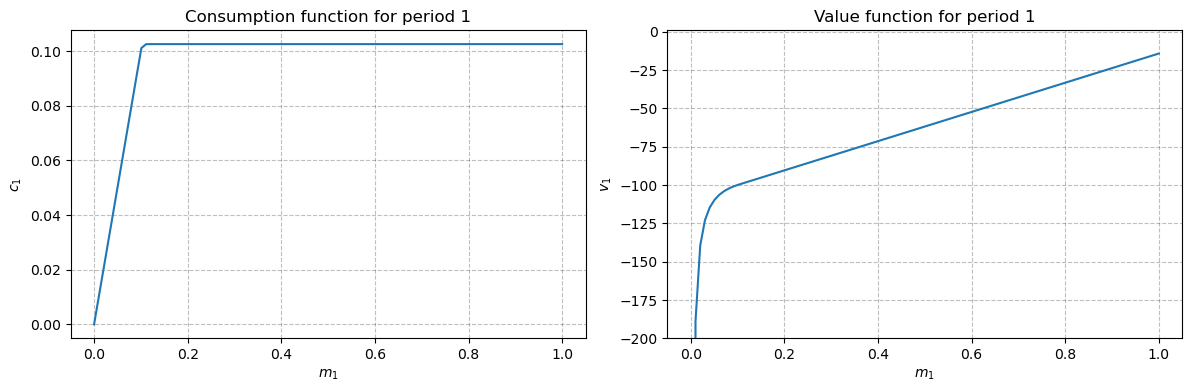

In [5]:
#To solve for period 1 we need to create an interpolater
v2_func_interp = interpolate.RegularGridInterpolator([m2_grid], v2_func, bounds_error=False, fill_value=None)

#Now we solve for Period 1
def solve_single_period(par, v_plus_interp):
    m_grid = np.linspace(1e-8, par.m1, par.N)
    v_func = np.empty(par.N)
    c_func = np.empty(par.N)
    
    for i, m in enumerate(m_grid):
        # Define the objective function to maximize
        obj = lambda c: -v(c, m, par, v_plus_interp)
        x0 = m / 2  # Initial guess of consumption
        result = optimize.minimize(obj, [x0], method='L-BFGS-B', bounds=((1e-8, m),))
        v_func[i] = -result.fun
        c_func[i] = result.x[0]
    
    return m_grid, v_func, c_func

#Create the interpolator for v_plus
v2_func_interp = interpolate.RegularGridInterpolator([m2_grid], v2_func, bounds_error=False, fill_value=None)

# Solve for period 1
m1_grid, v1_func, c1_func = solve_single_period(par, v2_func_interp)

# Setup the plots for the functions
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(m1_grid, c1_func)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('Consumption function for period 1')

ax = fig.add_subplot(1,2,2)
ax.plot(m1_grid, v1_func)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$v_1$')
ax.set_title('Value function for period 1')
ax.set_ylim([-200, 1])

fig.tight_layout(pad=1.0)
plt.show()

Here we see, that the consumer is faced with a problem in period 1. Since there is some uncertainty regarding her future cash-on-hand, which is decided by the standard random variables $\psi_2$ and $\nu_2$ that are approximated with $N$ random draws, the consumer knows that she will have to save some of her cash-on-hand for future consumption. This is why we see the so called "kink" in the consumption function.

In [6]:
def solve(par):
    
    #Solver for period 2
    m2_grid, v2_func, c2_func = solve_last_period(par)
    
    #Interpolater construction
    v2_func_interp = interpolate.RegularGridInterpolator([m2_grid], v2_func, bounds_error=False, fill_value=None)
    
    #Solver for period 1
    m1_grid, v1_func, c1_func = solve_single_period(par,v2_func_interp)
    
    return m1_grid, c1_func, m2_grid, c2_func


**Question 3:** Plot combinations of $(\pi,\sigma_{\psi})$ implying that $v(m_1)$ is unchanged. Comment.

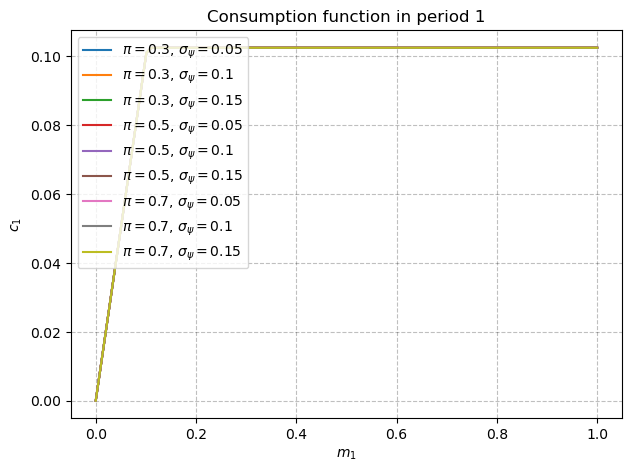

In [7]:
# Create arrays of different values for pi and sigma_psi
pi_values = [0.3, 0.5, 0.7]
sigma_psi_values = [0.05, 0.1, 0.15]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Store the original parameter values
_original_pi = par.pi
_original_sigma_psi = par.sigma_psi

# Loop over different combinations of pi and sigma_psi
for pi in pi_values:
    for sigma_psi in sigma_psi_values:
        par.pi = pi
        par.sigma_psi = sigma_psi

        m1_grid, c1_func, m2_grid, c2_func = solve(par)
        ax.plot(m1_grid, c1_func, label=f'$\pi = {pi}$, $\sigma_{{\psi}} = {sigma_psi}$')

# Restore the original parameter values
par.pi = _original_pi
par.sigma_psi = _original_sigma_psi

# Add labels, title, and legend to the plot
ax.legend(loc='upper left', facecolor='white', frameon=True)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('Consumption function in period 1')
fig.tight_layout(pad=1.0)
plt.show()


## 2. <a id='toc2_'></a>[Problem 2: Inflation in an exchange model](#toc0_)

Consider an exchange economy with two agents, $A$ and $B$ each with their own distinct good. Their endowment are $e_A$ and $e_B$. Agent $A$ is the buyer, she takes the relative price of the two goods, $p$, as given and chooses the amount of agent $B$'s good to exchange for her own. Agent $B$ is the seller, she sets the relative price between the goods, optimally taking into account $A$'s demand.

**Agent $A$, the buyer, solves:**
$$
\begin{align}
V_{A}(p) = \max_{c,c'} u_A(c,c') \\ s.t. \; c+pc'=e_{A} \\
\end{align}
$$
Or simply:
$$
\begin{align}
V_{A}(p) = \max_{c'} u_A(e_{A}-pc',c')  \\
\end{align}
$$
Where $c$ is consumption of her own good and $c'$ is consumption of the other good.<br>
$u_A$ is her utility function. <br>
This optimization yields the optimal demand function:
$$
\begin{align}
\Rightarrow c' = D(p)
\end{align}
$$

**Agent $B$, the seller, solves:**
\begin{align}
p^* \equiv \arg\max_p v_B(p) \\
\end{align}
where
\begin{align}
\;\,v_B(p) \equiv u_B(e_B-D(p),pD(p))
\end{align}

$u_B$ is her utility function in consumption of her own good (intital endowment, $e_B$, minus what is sold, $D(p)$), and consumption of the other good ($pD(p)$) obtained through trade. $v_B(p)$ is her indirect utility, when the price is $p$, taking into account the optimal demand of the buyer.

Assume that agents are symmetric with quasi-linear utility functions:
\begin{align}
u_A=u_B=u(c,c') = c+ \frac{(c')^{1-\frac{1}{\epsilon}} }{1-\frac{1}{\epsilon}}
\end{align}
And also have equal endownment $e_A = e_B=10$.

Assume the following parameter value:
- $\epsilon = 10.$

**Question 1:** Nummerically solve, and illustrate optimal demand of the buyer, $A$, in the range $p\in [1,2]$. Verify that what you find numerically is equal to the analytical solution, $D(p)=p^{-\epsilon},\,p\geq1$ 

In [8]:
#First we define the parameters
eps = 10.0
e_A = 10
e_B = 10

p_vec = np.linspace(1, 2, 1000) #We make 'contionusly' interval from 1 to 2 by letting there be 1000 samples in the interval

#We define the utility function
def u(c, c_mark):
    u = c + (c_mark**(1 - 1/eps)) / (1 - 1/eps)
    return u

#We nummerically solve the optimal demand of the buyer by maximize the utility function with respect to c_mark for every p in it's range.
def optimal_demand(p):
    demand_A = [] #We make a empty list for every optimal c_mark

    for p in p_vec: #We make a loop for every value of p in p_vec
        obj_func = lambda c_mark: -u(e_A - p*c_mark, c_mark) #We make a new function based on the utility function and insert the contraint
        result = minimize_scalar(obj_func, bounds=(0, e_B), method='bounded') #We maximize the function we made above with respect to c_mark
        c_mark_optimal = result.x #We call the c_mark, which maximize the utility, c_mark_optimal
        demand_A.append(c_mark_optimal) #We save the c_mark_optimal in empty list, we made earlier

    return demand_A #We let the list of the optimales c_mark be returned

#We create a plot to illustrate the optimal demand
plt.plot(p_vec, optimal_demand(p))
plt.title('Optimal demand of buyer A: numerical soultion')
plt.xlabel('Value of p')
plt.ylabel('Value of c´')
plt.show()

#We now compare our numerical soultion with the analytical solution
analytical_list = []
for p in p_vec:
    analytical_list.append(p**(-eps))
plt.plot(p_vec,analytical_list)
plt.title('Optimal demand of buyer A: analytical soultion')
plt.xlabel('Value of p')
plt.ylabel('Value of c´')
plt.show()




NameError: name 'p' is not defined

We see that the demand-curves after c' are the same for both the numerical and analytical soultion. We could also print all the values for both soultions and compare, but that would take to much space and be to big for python.

**Question 2:** Solve the seller's problem numerically, taking into account optimal demand of the buyer. Verify that what you find numerically is equal to the analytical solution: $p^* = \left(\frac{\epsilon}{\epsilon-1} \right)^\frac{\epsilon}{2\epsilon-1}$. <br>
*Hint:* For this problem you can use the analytical solution to $D(p)$, but it is recomended that you use the numerical solution to $D(p)$ from question 1, and nest that when solving the seller's problem, as you will need to do that in the next question.

In [ ]:
def demand_ex(p): #Make the numerical solution for optimal demand of buyer from question 1 to use for question 2.
    
    objective = lambda c_mark: -u(e_A - p*c_mark, c_mark)
    result = minimize_scalar(objective, bounds=(0, e_B), method='bounded')
    return result.x


def seller_prob(): #We make a "overall" function
    
    def u_seller (p): #We make a new utility function for the seller based on function u, where we insert the endownment and optimal demand of the buyer in it 
        c_mark_optimal = demand_ex(p)  #We call our optimal demand of the buyer from question 1 for c_mark_optimal.
        return -u(e_B - c_mark_optimal, p*c_mark_optimal) #return the new utility function with the endownment and optimal demand of the buyer

    result_seller = minimize_scalar(u_seller, bounds=(1, 2), method='bounded') #maximize the new utility function for the seller with respect to p
    p_star = result_seller.x #we call the optimal p for p_star_numerical

    return p_star

#We could also use the analytical soultion to D(p) like this
def seller_prob_2():
    def u_seller_2 (p): 
        return -u(e_B - p**(-eps), p*p**(-eps))

    result_seller_2 = minimize_scalar(u_seller_2, bounds=(1, 2), method='bounded') #maximize the new utility function for the seller with respect to p
    p_star_analytical = result_seller_2.x #we call the optimal p for p_star_numerical

    return p_star_analytical

#We calulate the correct optimal p, which maxizmize utility of the seller
p_star_correct = (eps/(eps-1))**(eps/(2*eps-1))

#We print all three optimal p, so see if they are the same
print(f'The numerical calulated optimal p, which maxizmize utility of the seller = {seller_prob():.3f}')
print(f'The analytical calulated optimal p, which maxizmize utility of the seller = {seller_prob_2():.3f}')
print(f'The correct optimal p, which maxizmize utility of the seller = {p_star_correct:.3f}')

Luckly for us the three optimal p are all the same. Our numerical and analytical method results in the optimal p being the same as the correct optimal p. 

Now consider a fully non-linear utility function, for both agents:
\begin{align}
u_A = u_B = u(c,c') = \frac{(c)^{1-\frac{1}{\eta}} }{1-\frac{1}{\eta}}+ \frac{(c')^{1-\frac{1}{\epsilon}} }{1-\frac{1}{\epsilon}}
\end{align}

**Question 3:** Solve for $p^*$ for the fully non-linear utility function, for $\eta \in \left\{1000,10\right\}$ <br>
*Hint:* Note that this requires both solving the buyer's problem and the seller's problem numerically. 

In [ ]:
#Define eta
etas = [10, 1000]  # Different values for eta

#Define utility function
def u_q3(c, c_mark_q3, eta):
    u_q3 = (c**(1 - 1/eta)) / (1 - 1/eta) + (c_mark_q3**(1 - 1/eps)) / (1 - 1/eps)
    return u_q3

#Optimal demand function for the buyer
def demand_buyer_q3(p, eta):
    
    def u_buy_q3(c_mark_q3): #We make a new utility function for the buyer based on u_q3 function, where we insert the constraint
        return -u_q3(e_A - p * c_mark_q3, c_mark_q3, eta)
    
    result_q3 = minimize_scalar(u_buy_q3, bounds=(0, e_A/p), method='bounded') #maximize the new utility function for the buyer with respect to c_mark_q3
    return result_q3.x #Return the optimal c_mark_q3

#Now we use the optimal demand function for the buyer from above to insert in the utility function of seller
def u_seller_q3(p, eta):
    c_mark_q3 = demand_buyer_q3(p, eta)
    return -u_B(e_B - c_mark_q3, p * c_mark_q3, eta)

# Optimize the seller's utility function to find optimal price
for eta in etas:
    optimal_result = minimize_scalar(v_B, bounds=(0, e_B), args=(eta,), method='bounded')
    optimal_price = optimal_result.x
    print(f"Optimal price p* (eta = {eta}) = {optimal_price:.2f}")

**Question 4:** Make two plots of $p^*$, both with $\eta=10$ and $e_{B}=10$: 
- One of how $p^*$ changes with $\epsilon\in \left[5,30\right]$ and $e_{A}=10$
- One of how $p^*$ changes with $e_{A}\in \left[2.5,30\right]$ and $\epsilon=10$

## 3. <a id='toc3_'></a>[Problem 3: Segregation model](#toc0_)

**Definitions:**

We imagine a world, which can be described by a $30\times30$ grid of *positions*.

Initially, each position is *filled* by a person with a 80 percent probability, and otherwise it is *empty*.

If *filled* initially, it is a fifty-fifty chance whether the person belongs to group *red* or group *blue*.

We define a *neighborhood* of a position as the up to 8 positions only one step away in either direction (up/down, left/right, corners).

A person is *satisfied* if her group is not the minority in her neighborhood,

**Each period the following things happen:**

1. A random person is given the possibility to move.

2. The chosen person search empty positions at random. 

3. A move happens immediatly when an unsatisfied person finds an empty position where she is satisfied, and the period ends.

The code below creates the initial map.

In [ ]:
np.random.seed(123)
dim = 30
map = np.random.choice([0,1,2],size=(dim,dim),p=[0.20,0.40,0.40])

def display(map):
    
    cmap = colors.ListedColormap(['white','red', 'blue'])
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1)
    ax.grid(False)
    ax.pcolormesh(map,edgecolor='black',cmap=cmap)
    plt.show()

display(map)

**Question:** Simulate forwards for 10,000 periods and show how the world looks. Calculate the initial and final average number of same-group persons in the neighborhood of each person. Comment. <br>*You can use the code below with the functions `neigborhood` and `satisfied` to start from*.

In [ ]:
def neighborhood(group,i,j):
    """ find the number of same and different persons as group in the neighborhood of (i,j) 

    Args:

        group (int): group number [1,2]
        i (int): row index
        j (int): column index

    Returns:

        same (int): number of persons in same group
        different (int): number of persons in different group
        
    """

    same = 0
    different = 0
    for i_ in range(i-1,i+2): # i-1,i,i+1
        for j_ in range(j-1,j+2): # j-1,j,j+1
            
            # outside the map
            if i_ < 0 or i_ >= dim or j_ < 0 or j_ >= dim:
                continue

            # same person
            if i_ == i and j_ == j:
                continue
            
            # empty position
            if map[i_,j_] == 0:
                continue

            # same or different group
            if map[i_,j_] == group:
                same += 1
            else:
                different += 1   

    return same,different

In [ ]:
def satisfied(group,i,j):
    """ check if person from group would be satisfied at (i,j)
        
    Args:

        group (int): group number [1,2]
        i (int): row index
        j (int): column index

    Output:

        bool: True if satisfied, False otherwise
       
    """

    same,different = neighborhood(group,i,j)        
            
    if same >= different:
        return True
    else:
        return False
    

**Finding Initial Average Same-Group Neighbors:**

In [ ]:
# Initialize counters and accumulators for calculating averages
neighbor_counts = [0, 0, 0]  # [0] for empty positions, [1] for red, [2] for blue
same_group_count = [0, 0, 0]  # [0] for empty positions, [1] for red, [2] for blue

# Iterate over each position in the grid
for i in range(dim):
    for j in range(dim):
        group = map[i, j]
        same, _ = neighborhood(group, i, j)
        neighbor_counts[group] += 1
        same_group_count[group] += same

# Calculate and print the initial average number of same-group persons in the neighborhood for each group
for group in [1, 2]:
    average = same_group_count[group] / neighbor_counts[group]
    print(f"Group {group}: Initial Average Same-Group Neighbors = {average:.2f}")

**Simulating and finding Final Average Same-Group Neighbors:**

In [ ]:
# Simulate forward for 10000 periods
for period in range(10000):
    i, j = np.random.randint(dim), np.random.randint(dim)  # Choose a random person to potentially move

    if map[i, j] != 0:  # Skip empty positions
        empty_positions = np.argwhere(map == 0)  # Find all empty positions
        np.random.shuffle(empty_positions)  # Shuffle empty positions randomly

        for empty_i, empty_j in empty_positions:
            if satisfied(map[i, j], empty_i, empty_j):
                map[empty_i, empty_j] = map[i, j]  # Move the person to the empty position
                map[i, j] = 0  # Mark the original position as empty
                break  # Move successful, end the period

# Display the final state of the world
display(map)

# Initialize counters and accumulators for calculating final averages
final_neighbor_counts = [0, 0, 0]  # [0] for empty positions, [1] for red, [2] for blue
final_same_group_count = [0, 0, 0]  # [0] for empty positions, [1] for red, [2] for blue

# Iterate over each position in the final grid
for i in range(dim):
    for j in range(dim):
        group = map[i, j]
        same, _ = neighborhood(group, i, j)
        final_neighbor_counts[group] += 1
        final_same_group_count[group] += same

# Calculate and print the final average number of same-group persons in the neighborhood for each group
for group in [1, 2]:
    average = final_same_group_count[group] / final_neighbor_counts[group]
    print(f"Group {group}: Final Average Same-Group Neighbors = {average:.2f}")

We see an increase in the number of Average Same-Group Neighbors. This was expected as people over 10000 simulations should be able to find a neighbor of the same group. The increase is just under double the amount of the initial value as it goes from 3.16 to 5.77 for red and 2.86 to 5.55 for blue. \
If we did the simulation 10000 times more we would see an increase once again. We would not expect the increase to be as large though because there is an upper bound to how many same-group neighbors are possible. \
We could show this by simply repeating the code above.

In [ ]:
# Simulate forward for 10000 periods
for period in range(10000):
    i, j = np.random.randint(dim), np.random.randint(dim)  # Choose a random person to potentially move

    if map[i, j] != 0:  # Skip empty positions
        empty_positions = np.argwhere(map == 0)  # Find all empty positions
        np.random.shuffle(empty_positions)  # Shuffle empty positions randomly

        for empty_i, empty_j in empty_positions:
            if satisfied(map[i, j], empty_i, empty_j):
                map[empty_i, empty_j] = map[i, j]  # Move the person to the empty position
                map[i, j] = 0  # Mark the original position as empty
                break  # Move successful, end the period

# Display the final state of the world
display(map)

# Initialize counters and accumulators for calculating final averages
final_neighbor_counts = [0, 0, 0]  # [0] for empty positions, [1] for red, [2] for blue
final_same_group_count = [0, 0, 0]  # [0] for empty positions, [1] for red, [2] for blue

# Iterate over each position in the final grid
for i in range(dim):
    for j in range(dim):
        group = map[i, j]
        same, _ = neighborhood(group, i, j)
        final_neighbor_counts[group] += 1
        final_same_group_count[group] += same

# Calculate and print the final average number of same-group persons in the neighborhood for each group
for group in [1, 2]:
    average = final_same_group_count[group] / final_neighbor_counts[group]
    print(f"Group {group}: Final Average Same-Group Neighbors = {average:.2f}")